In [1]:
import math
import joblib
import keras

import numpy as np
import scipy as sp
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras import activations, layers, initializers
from keras.models import Model
from keras.optimizers.legacy import Adam

from src.inn_layers_v2 import IntAdd, IntDense, IntConv2D, IntDropout, IntFlatten, IntMultiply, IntSilu, IntGelu
from src.inn_layers_v2 import IntZeroPadding2D, IntBatchNormalization, IntRelu, IntTanh, IntMultiply_donet
from src.deeponet_wrapper import trainer

from matplotlib import pyplot as plt
import matplotlib.patches as patches
from src import inn_layers_v2 as innv2
from src import grid_augmentation as ga
from src import clust_augmentation as ca

import scienceplots
plt.style.use('science')

import warnings
warnings.filterwarnings("ignore")


In [2]:
params = {'xtick.labelsize':12,
          'ytick.labelsize':12,
          'axes.labelsize': 16,
          'axes.titlesize': 18}
plt.rcParams.update(params)

## Standard precise dataset

In [3]:
u_in = np.load("data/poisson1Dinput.npy")
g_out = np.load("data/poisson1Doutput.npy") * 20  # the output from u_in_lo is actually lower

y_space = np.linspace(0,1,u_in.shape[1])

## Ground truth interval data

In [4]:
u_in_lo = np.load("data/poisson1Dinput_low.npy")
u_in_hi = np.load("data/poisson1Dinput_high.npy")

g_out_lo = np.load("data/poisson1Doutput_high.npy") * 20  # the output from u_in_lo is actually lower
g_out_hi = np.load("data/poisson1Doutput_low.npy") * 20

In [5]:
u_int_0 = np.stack([u_in_lo, u_in_hi], axis=-1)
g_int_0 = np.stack([g_out_lo, g_out_hi], axis=-1)

### Train-Test split

In [6]:
n_total = u_in.shape[0] #2000
n_test = 1000  # thus, n_train = 1000
n_val = 100
rand = 42
idxs = np.arange(u_in.shape[0])
idx_train, idx_test = train_test_split(idxs, test_size=n_test/n_total, 
                                        random_state=rand)
idx_val, idx_test = train_test_split(idx_test, train_size=n_val/n_test, 
                                        random_state=rand)

In [7]:
u_int = np.expand_dims(u_int_0, axis=1)
g_int = np.expand_dims(g_int_0, axis=2)

In [8]:
## Pointwise data split
u_train, u_val, u_test = u_in[idx_train,...], u_in[idx_val,...], u_in[idx_test,...]
g_train, g_val, g_test = g_out[idx_train,...], g_out[idx_val,...], g_out[idx_test,...]

## Interval data split
_,u_int_val, u_int_test = u_int[idx_train,...], u_int[idx_val,...], u_int[idx_test,...]
_,g_int_val, g_int_test = g_int[idx_train,...], g_int[idx_val,...], g_int[idx_test,...]

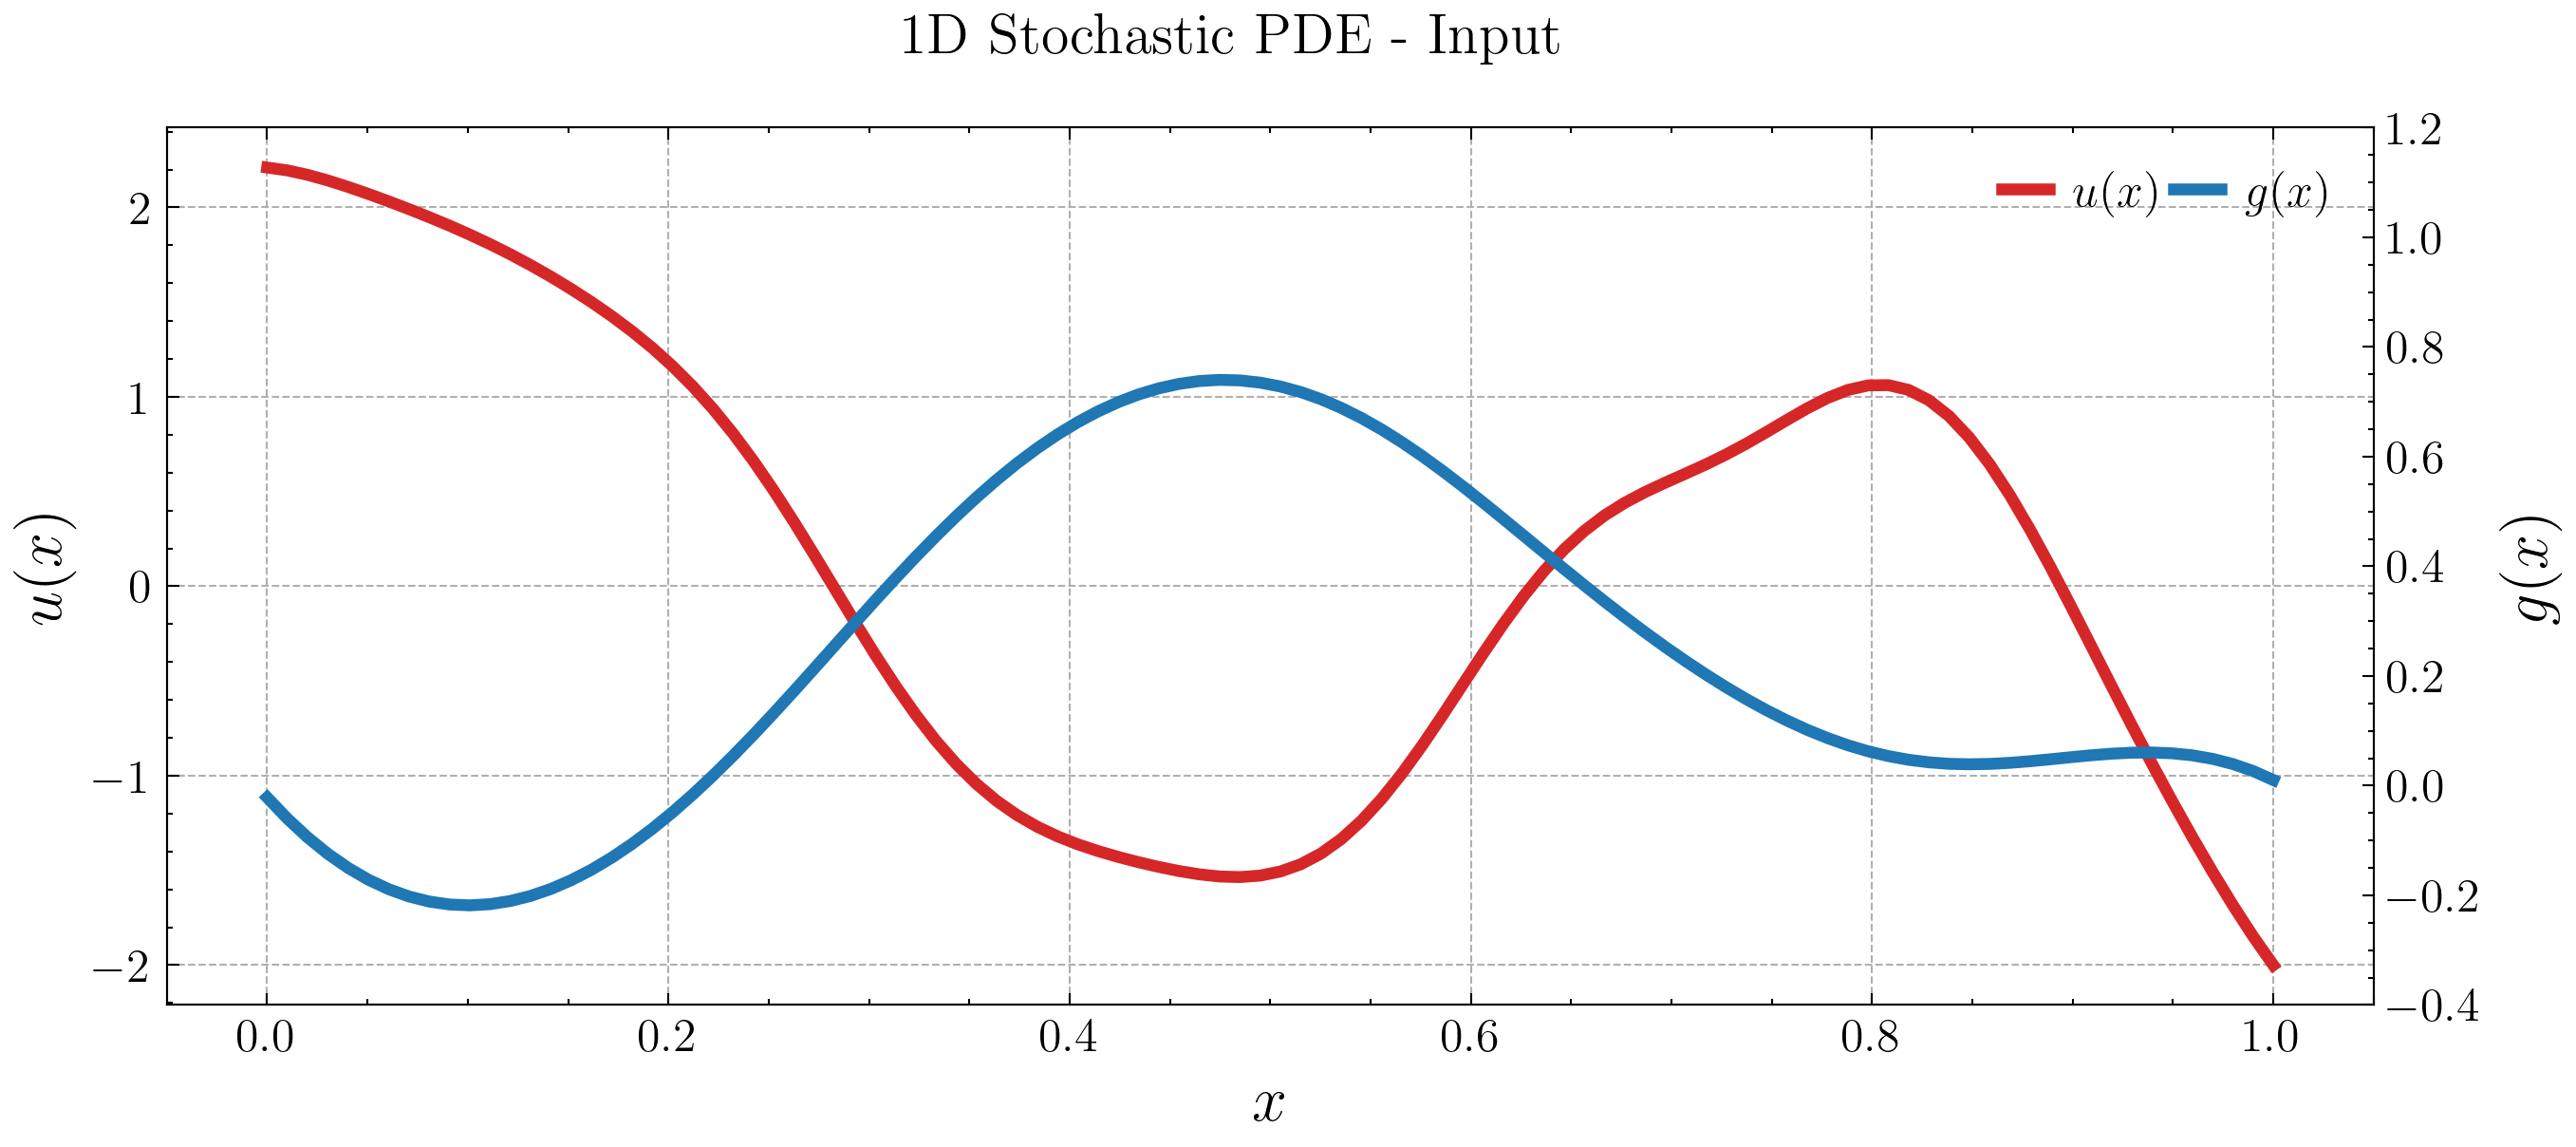

In [9]:
plt.rcParams['font.family'] = 'Times New Roman' 
plt.rcParams['font.size'] = 12
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

colormap = plt.cm.jet  
colors = [colormap(i) for i in np.linspace(0, 5, 20)]

fig2, ax1 = plt.subplots(figsize = (10, 4), dpi=300)
fig2.suptitle('1D Stochastic PDE - Input')

index = 0
i = 42
color = 'tab:red'
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$u(x)$')
# ax1.plot(y_space, u_int_test[i,:,:,0].T, '--', color=color)
line1 = ax1.plot(y_space, u_test[i,:].T, '-', color=color, linewidth=3, label=r'$u(x)$')
# ax1.plot(y_space, u_int_test[i,:,:,1].T, '--', color=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel(r'$g(x)$')
# ax2.plot(y_space, g_int_test[i,:,:,0], '--', color=color)
line2 = ax2.plot(y_space, g_test[i,:].T, '-', color=color, linewidth=3, label=r'$g(x)$')
# ax2.plot(y_space, g_int_test[i,:,:,1], '--', color=color)
ax2.set_ylim(-0.4, 1.2)

# Combine legends from both axes
lines = [line1[0], line2[0]]
labels = [line.get_label() for line in lines]
plt.legend(lines, labels, loc='upper right', ncol=4, labelspacing=0.25, 
           columnspacing=0.25, handletextpad=0.5, handlelength=1)

ax1.grid(True, axis='both', linestyle='--', linewidth=0.5)
plt.margins(0)

plt.savefig("img/pointwise_1dPDE.pdf", dpi=300, format="pdf")
plt.show()

### Data Augmentation

In [10]:
# grid_res = [[a]*u_train.shape[1] for a in [15]]
# u_aug_train, g_aug_train = ga.construct_interval_grid(u_train, g_train, 
#                                                      grid_res=grid_res, n_shift=2, nmax_per_res=25)

In [11]:
u_aug_train_0, g_aug_train_0, u_clust, g_clust = ca.construct_interval(u_train, g_train, n_clusters=[5,10,20,50,75,100,150,200,300])

100%|██████████| 9/9 [00:11<00:00,  1.24s/it]


In [12]:
u_aug_train = np.expand_dims(u_aug_train_0, axis=1)
g_aug_train = np.expand_dims(g_aug_train_0, axis=2)

In [13]:
u_aug_train.shape, g_aug_train.shape

((814, 1, 100, 2), (814, 100, 1, 2))

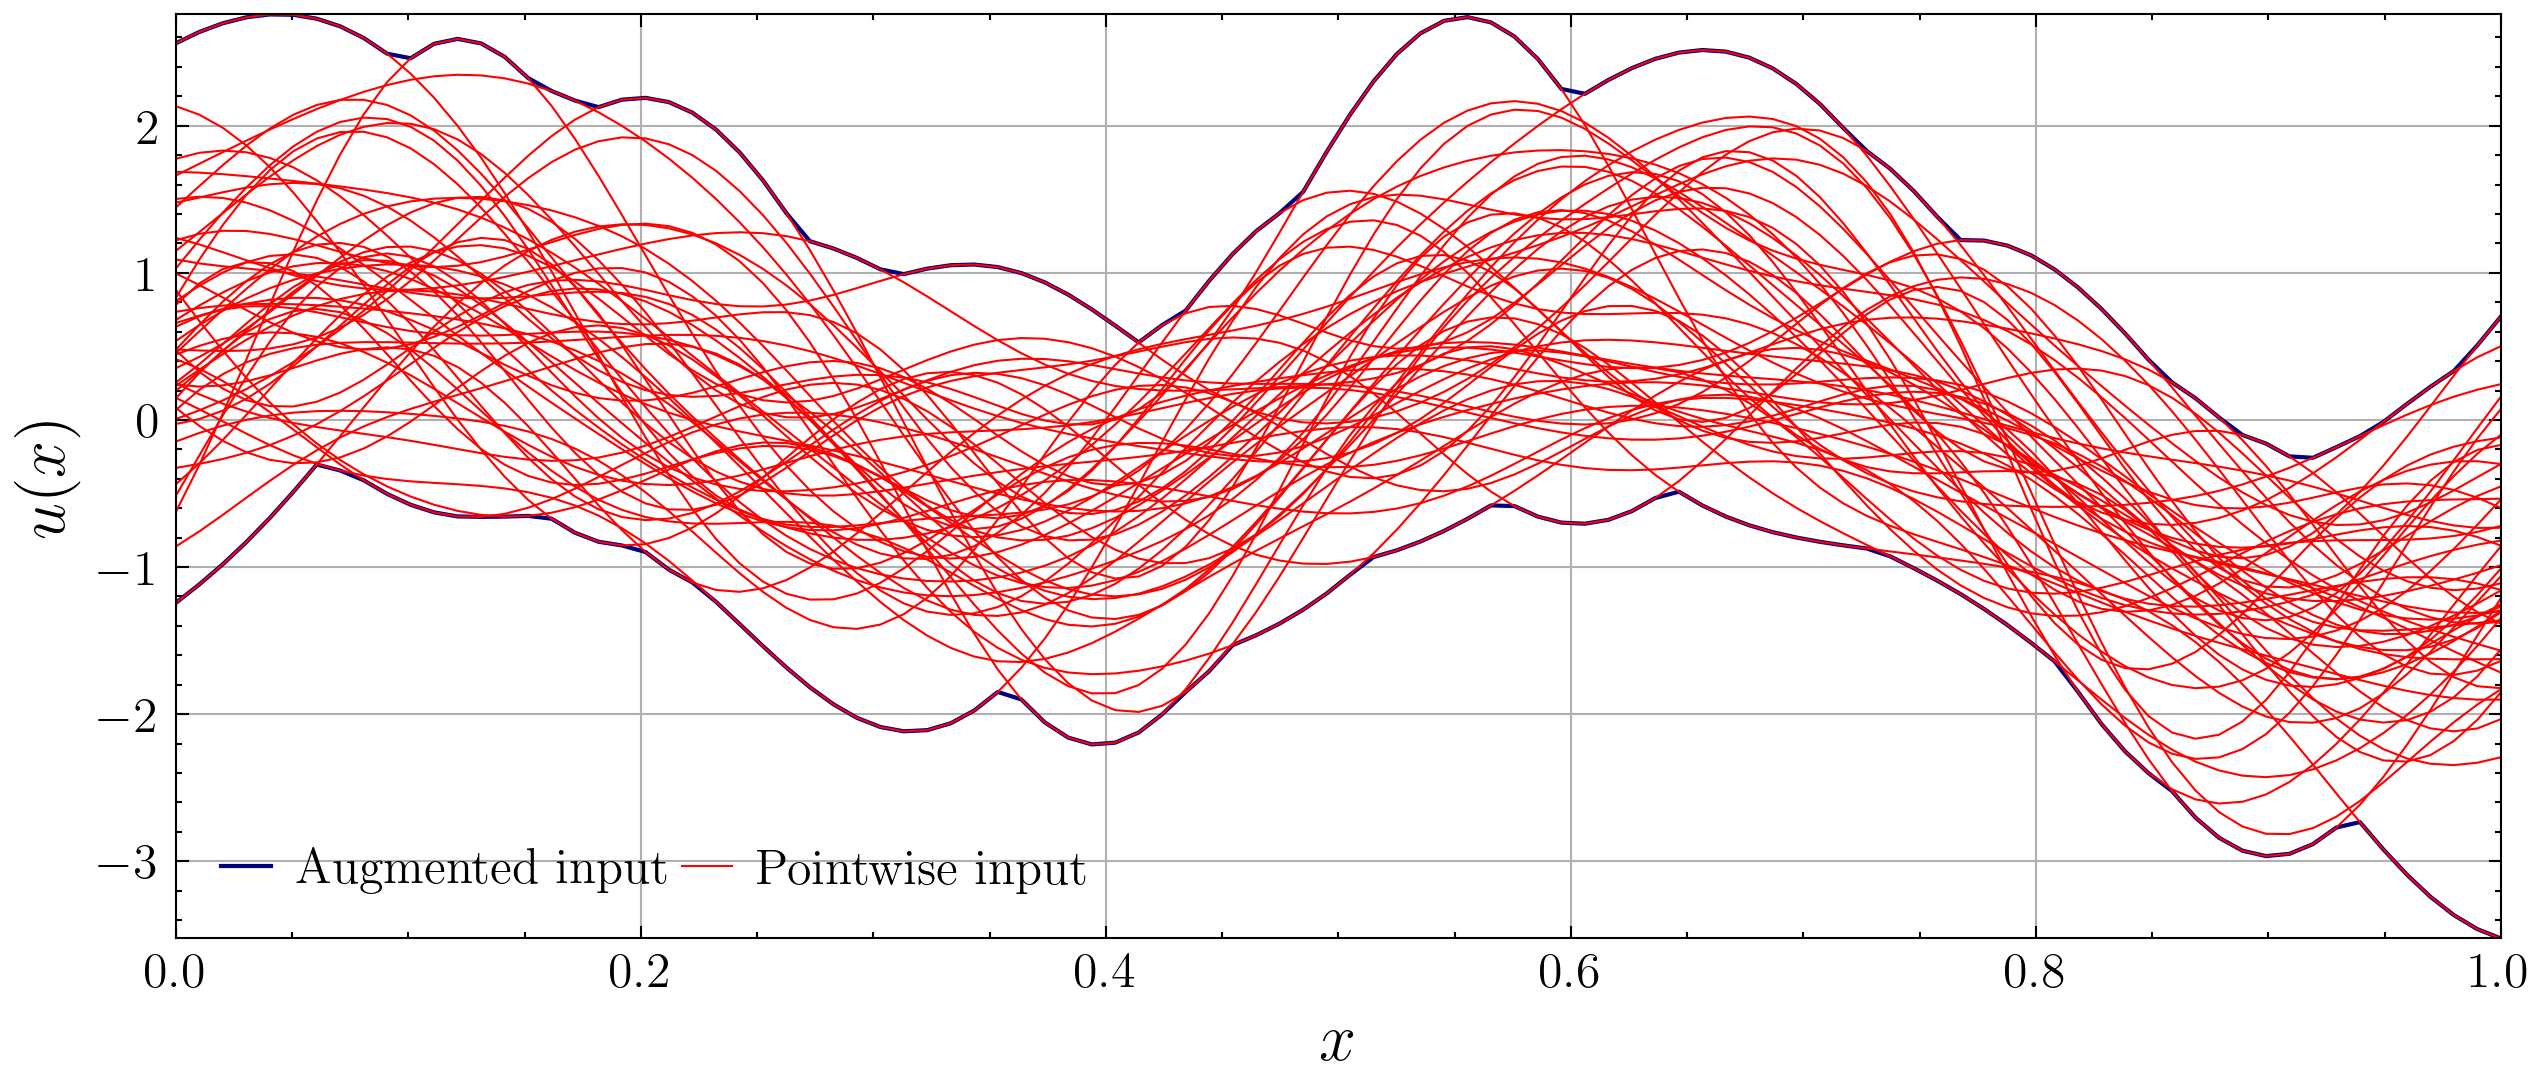

In [14]:
plt.rcParams['font.family'] = 'Times New Roman' 
plt.rcParams['font.size'] = 12
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

colormap = plt.cm.jet  
colors = [colormap(i) for i in np.linspace(0, 5, 20)]

fig2 = plt.figure(figsize = (10, 4), dpi=300)
# fig2.suptitle('1D Stochastic PDE - Augmented input')

index = 0
for i in [17]:
    plt.plot(y_space, u_aug_train[i,:,:,0].T, '-', color=colors[index], label='Augmented input')
    plt.plot(y_space, u_aug_train[i,:,:,1].T, '-', color=colors[index])
    for idxuc, uc in enumerate(u_clust[i]):
        if idxuc == 0:
            plt.plot(y_space, uc.T, '-', color="red", linewidth=0.5, label="Pointwise input")
        else:
            plt.plot(y_space, uc.T, '-', color="red", linewidth=0.5)
    index += 1
plt.legend(ncol=4, loc=3, labelspacing=0.25, columnspacing=0.25, handletextpad=0.5, handlelength=1)
plt.grid(True)
plt.margins(0)
plt.xlabel(r'$x$')
plt.ylabel(r'$u(x)$')

plt.savefig("img/augmented_input_1dpde.pdf", dpi=300, format="pdf")
plt.show()

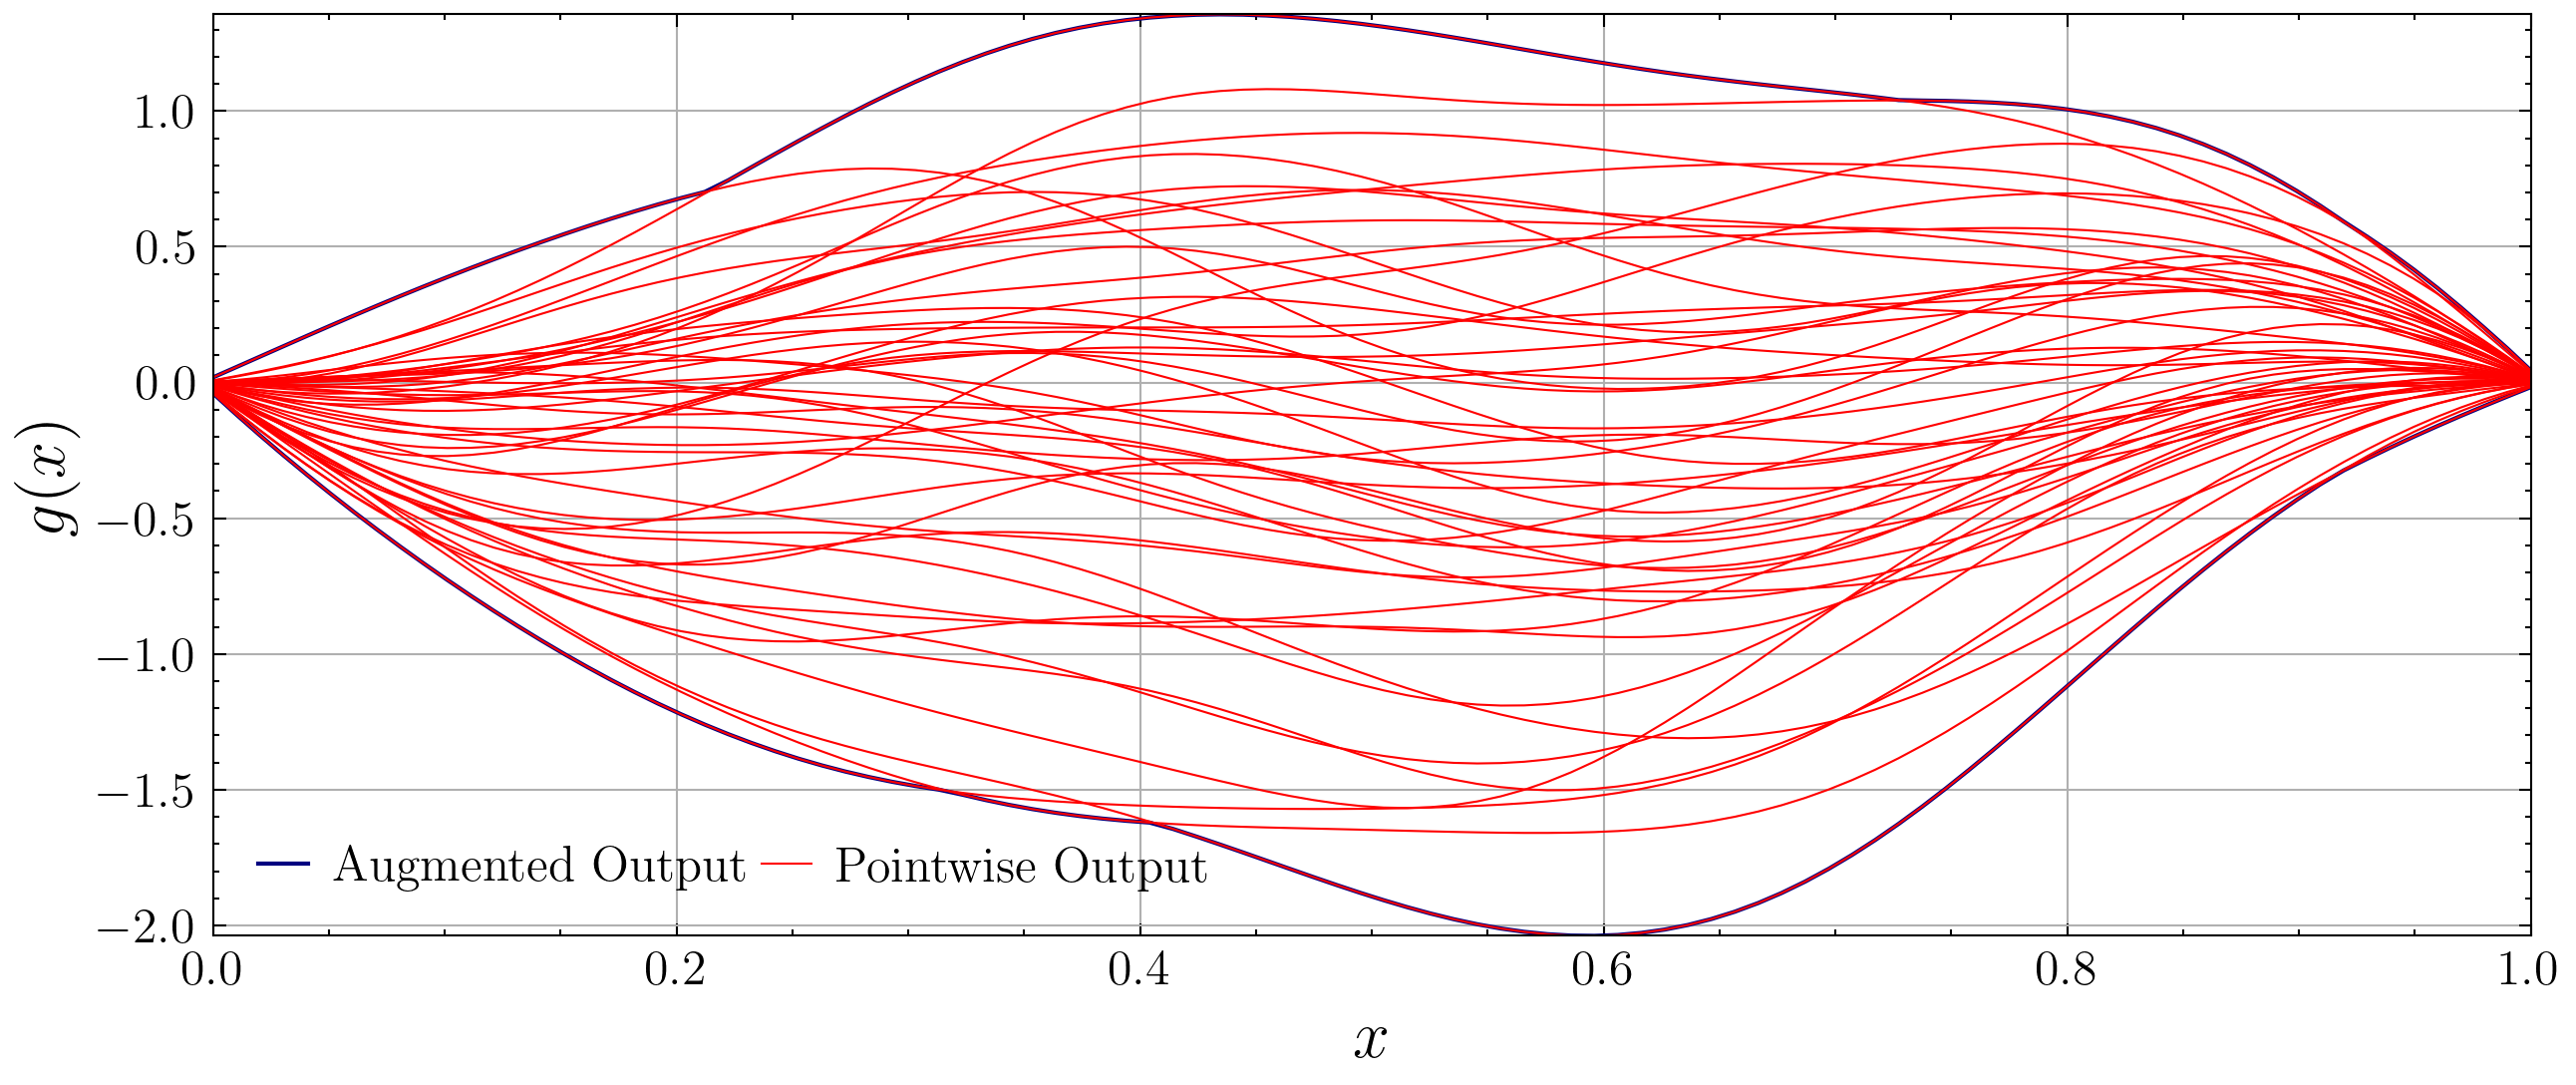

In [15]:
plt.rcParams['font.family'] = 'Times New Roman' 
plt.rcParams['font.size'] = 12
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

colormap = plt.cm.jet  
colors = [colormap(i) for i in np.linspace(0, 5, 20)]

fig2 = plt.figure(figsize = (10, 4), dpi=300)
# fig2.suptitle('1D Stochastic PDE - Augmented Output')

index = 0
for i in [17]:
    plt.plot(y_space, g_aug_train[i,:,:,0], '-', color=colors[index], label='Augmented Output')
    plt.plot(y_space, g_aug_train[i,:,:,1], '-', color=colors[index])
    for idxgc, gc in enumerate(g_clust[i]):
        if idxgc == 0:
            plt.plot(y_space, gc.T, '-', color="red", linewidth=0.5, label="Pointwise Output")
        else:
            plt.plot(y_space, gc.T, '-', color="red", linewidth=0.5)
    index += 1
plt.legend(ncol=4, loc=3, labelspacing=0.25, columnspacing=0.25, handletextpad=0.5, handlelength=1)
plt.grid(True)
plt.margins(0)
plt.xlabel(r'$x$')
plt.ylabel(r'$g(x)$')

plt.savefig("img/augmented_output_1dpde.pdf", dpi=300, format="pdf")
plt.show()

In [16]:
pde_dict = dict()
pde_dict['input_intv_low'] = u_aug_train[i,:,:,0]
pde_dict['input_intv_high'] = u_aug_train[i,:,:,1]
pde_dict['input_clust'] = u_clust[i]

pde_dict['output_intv_low'] = g_aug_train[i,:,:,0]
pde_dict['output_intv_high'] = g_aug_train[i,:,:,1]
pde_dict['output_clust'] = g_clust[i]

joblib.dump(pde_dict, "output/augmented_1dpde.pkl")

['output/augmented_1dpde.pkl']

## DeepONet

In [17]:
def build_mlp(inputs, output_features: int, 
              hidden_features: int, num_hidden_layers: int):
    """
    Builds an MLP regression model.
    
    Parameters:
        x: Input tensor.
        output_features (int): Number of output features.
        hidden_features (int): Number of units in each hidden layer.
        num_hidden_layers (int): Number of hidden layers.
    
    Returns:
        array: keras tensor.
    """
    x = inputs
    
    # Create hidden layers with tanh activation
    for i in range(num_hidden_layers):
        x = layers.Dense(hidden_features, activation='silu', name=f"trunk_{i}")(x)

    # Output layer with linear activation for regression
    outputs = layers.Dense(output_features, activation='linear', name="trunk_final")(x)
    
    return outputs

def build_nimlp(inputs, output_features: int, 
              hidden_features: int, num_hidden_layers: int):
    """
    Builds an Interval MLP regression model.
    
    Parameters:
        x: Input tensor.
        output_features (int): Number of output features.
        hidden_features (int): Number of units in each hidden layer.
        num_hidden_layers (int): Number of hidden layers.
    
    Returns:
        array: keras tensor.
    """
    x = inputs
    
    # Create hidden layers with tanh activation
    for i in range(num_hidden_layers):
        x = layers.Dense(hidden_features, activation="silu", name=f"branch_{i}")(x)

    # Output layer with linear activation for regression
    outputs = layers.Dense(output_features,  activation='linear', name="branch_final")(x)
    
    return outputs

In [18]:
def interval_deeponet(y_in_size, u_in_size, trunk_params, branch_params, out_feat=1):
    """_summary_

    Args:
        y_in_size (tuple): spatial input size
        u_in_size (tuple): function input size
        trunk_params (dict): trunk net parameters
        branch_params (dict): branch net parameters
        out_feat (int, optional): number of output feature. Defaults to 1.

    Returns:
        keras.Model: output model
    """
    y_input = layers.Input(y_in_size, name="y_input")
    u_input = layers.Input(u_in_size, name="u_input")

    # Trunk layer
    # y_in_lo = y_input[...,0]
    # y_in_hi = y_input[...,1]
    # y_in = [y_in_lo, y_in_hi]
    trunk_out = build_mlp(y_input, trunk_params["output_features"], 
                          trunk_params["hidden_features"], trunk_params["num_hidden_layers"])
    
    # Branch layer
    branch_out = build_nimlp(u_input, branch_params["output_features"], 
                                branch_params["hidden_features"], branch_params["num_hidden_layers"])

    # Multiply trunk and branch
    first_u = layers.Lambda(lambda t: t[..., 0:64])(branch_out)  # shape = (batch_size, 64)
    second_u = layers.Lambda(lambda t: t[..., 64:128])(branch_out) # shape = (batch_size, 64)
    mult1 = layers.Multiply()([trunk_out, first_u])
    mult2 = layers.Multiply()([trunk_out, second_u])
    merged = layers.Concatenate(axis=-1)([mult1, mult2])

    out = layers.Dense(out_feat, name="output_layer")(merged)

    model = Model(inputs=[y_input, u_input], outputs=out, name="DeepONet")

    return model

In [19]:
trunk_params=dict()
trunk_params["output_features"] = 64
trunk_params["hidden_features"] = 64
trunk_params["num_hidden_layers"] = 4

branch_params=dict()
branch_params["output_features"] = 128
branch_params["hidden_features"] = 64
branch_params["num_hidden_layers"] = 4

In [20]:
onet = interval_deeponet(y_in_size=(100,1), u_in_size=(1,200), trunk_params=trunk_params, 
                branch_params=branch_params, out_feat=2)

2025-12-03 14:41:09.662362: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-12-03 14:41:09.662385: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-12-03 14:41:09.662392: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-12-03 14:41:09.662617: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-03 14:41:09.663012: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [21]:
def linex(a):
    def linex_loss(target,y_pred):
        """Linear-exponential loss"""
        b = 2
        d1 = target[...,0,0] - y_pred[...,0]
        d2 = y_pred[...,1] - target[...,0,1]
        term1 = b*(tf.exp(-a*d1)+(a*d1)-1)
        term2 = b*(tf.exp(-a*d2)+(a*d2)-1)
        return tf.reduce_mean(term1 + term2)

    return linex_loss

def custom_loss(target, y_pred):
    term1 = tf.square((target[...,0,0] - y_pred[...,0]))
    term2 = tf.square((target[...,0,1] - y_pred[...,1]))
    loss = tf.reduce_mean(term1+term2)

    return loss

In [22]:
y_space_train = np.expand_dims(np.tile(y_space,(u_aug_train.shape[0],1)), axis=-1)
y_space_val = np.expand_dims(np.tile(y_space,(u_int_val.shape[0],1)), axis=-1)
y_space_test = np.expand_dims(np.tile(y_space,(u_int_test.shape[0],1)), axis=-1)

In [23]:
y_space_train.shape, u_aug_train.shape, g_aug_train.shape

((814, 100, 1), (814, 1, 100, 2), (814, 100, 1, 2))

In [24]:
class DelayedBestWeights(tf.keras.callbacks.Callback):
    def __init__(self, monitor='loss', mode='min', start_epoch=100):
        super().__init__()
        self.monitor = monitor
        self.mode = mode
        self.start_epoch = start_epoch
        self.best_value = np.inf if mode == 'min' else -np.inf
        self.best_weights = None

    def on_epoch_end(self, epoch, logs=None):
        current_value = logs.get(self.monitor)
        if epoch >= self.start_epoch:
            if (self.mode == 'min' and current_value < self.best_value) or \
               (self.mode == 'max' and current_value > self.best_value):
                self.best_value = current_value
                self.best_weights = self.model.get_weights()
                print(f" Best weights updated at epoch {epoch+1} with {self.monitor}={current_value:.4f}")

    def on_train_end(self, logs=None):
        if self.best_weights is not None:
            self.model.set_weights(self.best_weights)
            print(f"Restored best model from epoch after {self.start_epoch} "
                  f"with {self.monitor}={self.best_value:.4f}")
        else:
            print(f"No improvement found after epoch {self.start_epoch}")

In [25]:
def run_experiment(trunk_params, branch_params, u_int_train, y_int_train, g_int_train,
                   u_int_val, y_int_val, g_int_val,
                   u_int_test, y_int_test, g_int_test,
                   repetitions=10, n_train = 500, epochs=500, verbose=False):
    """Run the experiment with the given model and data."""

    results = []

    # Choose n_train random as training data
    for seed in tqdm(range(repetitions)):
        # Compile model
        model = interval_deeponet(y_in_size=(100,1), u_in_size=(1,200), trunk_params=trunk_params, 
                branch_params=branch_params, out_feat=2)
        model.compile(
            optimizer=keras.optimizers.legacy.Adam(learning_rate=1e-3),
            loss=custom_loss
        )

        data = dict()
        np.random.seed(seed)
        idx = np.random.choice(np.arange(u_int_train.shape[0]), size=n_train, replace=False)
        u_train_int = u_int_train[idx,...]
        y_train_int = y_int_train[idx,...]
        g_train_int = g_int_train[idx,...]

        u_int_train_in = np.concatenate([u_train_int[...,0], u_train_int[...,1]], axis=-1)
        u_int_val_in = np.concatenate([u_int_val[...,0], u_int_val[...,1]], axis=-1)

        best_weights_cb = DelayedBestWeights(monitor='val_loss', mode='min', start_epoch=100)

        # Train model
        hist = model.fit(x=[y_train_int, u_int_train_in], y=g_train_int, 
                   validation_data=([y_int_val, u_int_val_in], g_int_val), 
                   epochs=epochs, callbacks=[best_weights_cb], verbose=verbose)

        # Evaluate model
        u_int_test_in = np.concatenate([u_int_test[...,0], u_int_test[...,1]], axis=-1)
        pred = model.predict([y_int_test, u_int_test_in])
        data["u_train"] = u_train_int
        data["y_train"] = y_train_int
        data["g_train"] = g_train_int
        data["u_test"] = u_int_test
        data["y_test"] = y_int_test
        data["g_test"] = g_int_test
        data["pred"] = pred
        data["history"] = hist.history

        results.append(data)
        
    return results

In [26]:
results = run_experiment(trunk_params, branch_params, u_aug_train, y_space_train, g_aug_train,
                   u_int_val, y_space_val, g_int_val,
                   u_int_test, y_space_test, g_int_test,
                   repetitions=1, n_train=250, epochs=600, verbose=False)
joblib.dump(results, "output/deeponet1d_aug_naive_ntrain250.pkl")

  0%|          | 0/1 [00:00<?, ?it/s]2025-12-03 14:41:10.727645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


 Best weights updated at epoch 101 with val_loss=0.1751
 Best weights updated at epoch 102 with val_loss=0.1583
 Best weights updated at epoch 143 with val_loss=0.1581
 Best weights updated at epoch 149 with val_loss=0.1544
 Best weights updated at epoch 150 with val_loss=0.1515
 Best weights updated at epoch 154 with val_loss=0.1509
 Best weights updated at epoch 156 with val_loss=0.1445
 Best weights updated at epoch 157 with val_loss=0.1438
 Best weights updated at epoch 159 with val_loss=0.1396
 Best weights updated at epoch 162 with val_loss=0.1334
 Best weights updated at epoch 173 with val_loss=0.1310
 Best weights updated at epoch 174 with val_loss=0.1280
 Best weights updated at epoch 177 with val_loss=0.1267
 Best weights updated at epoch 178 with val_loss=0.1248
 Best weights updated at epoch 194 with val_loss=0.1227
 Best weights updated at epoch 285 with val_loss=0.1205
 Best weights updated at epoch 402 with val_loss=0.1186
 Best weights updated at epoch 427 with val_loss

100%|██████████| 1/1 [02:42<00:00, 162.33s/it]


['output/deeponet1d_aug_naive_ntrain250.pkl']

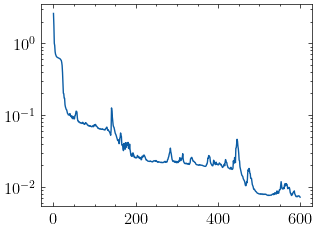

In [27]:
plt.semilogy(results[0]['history']['loss'])

## Predict

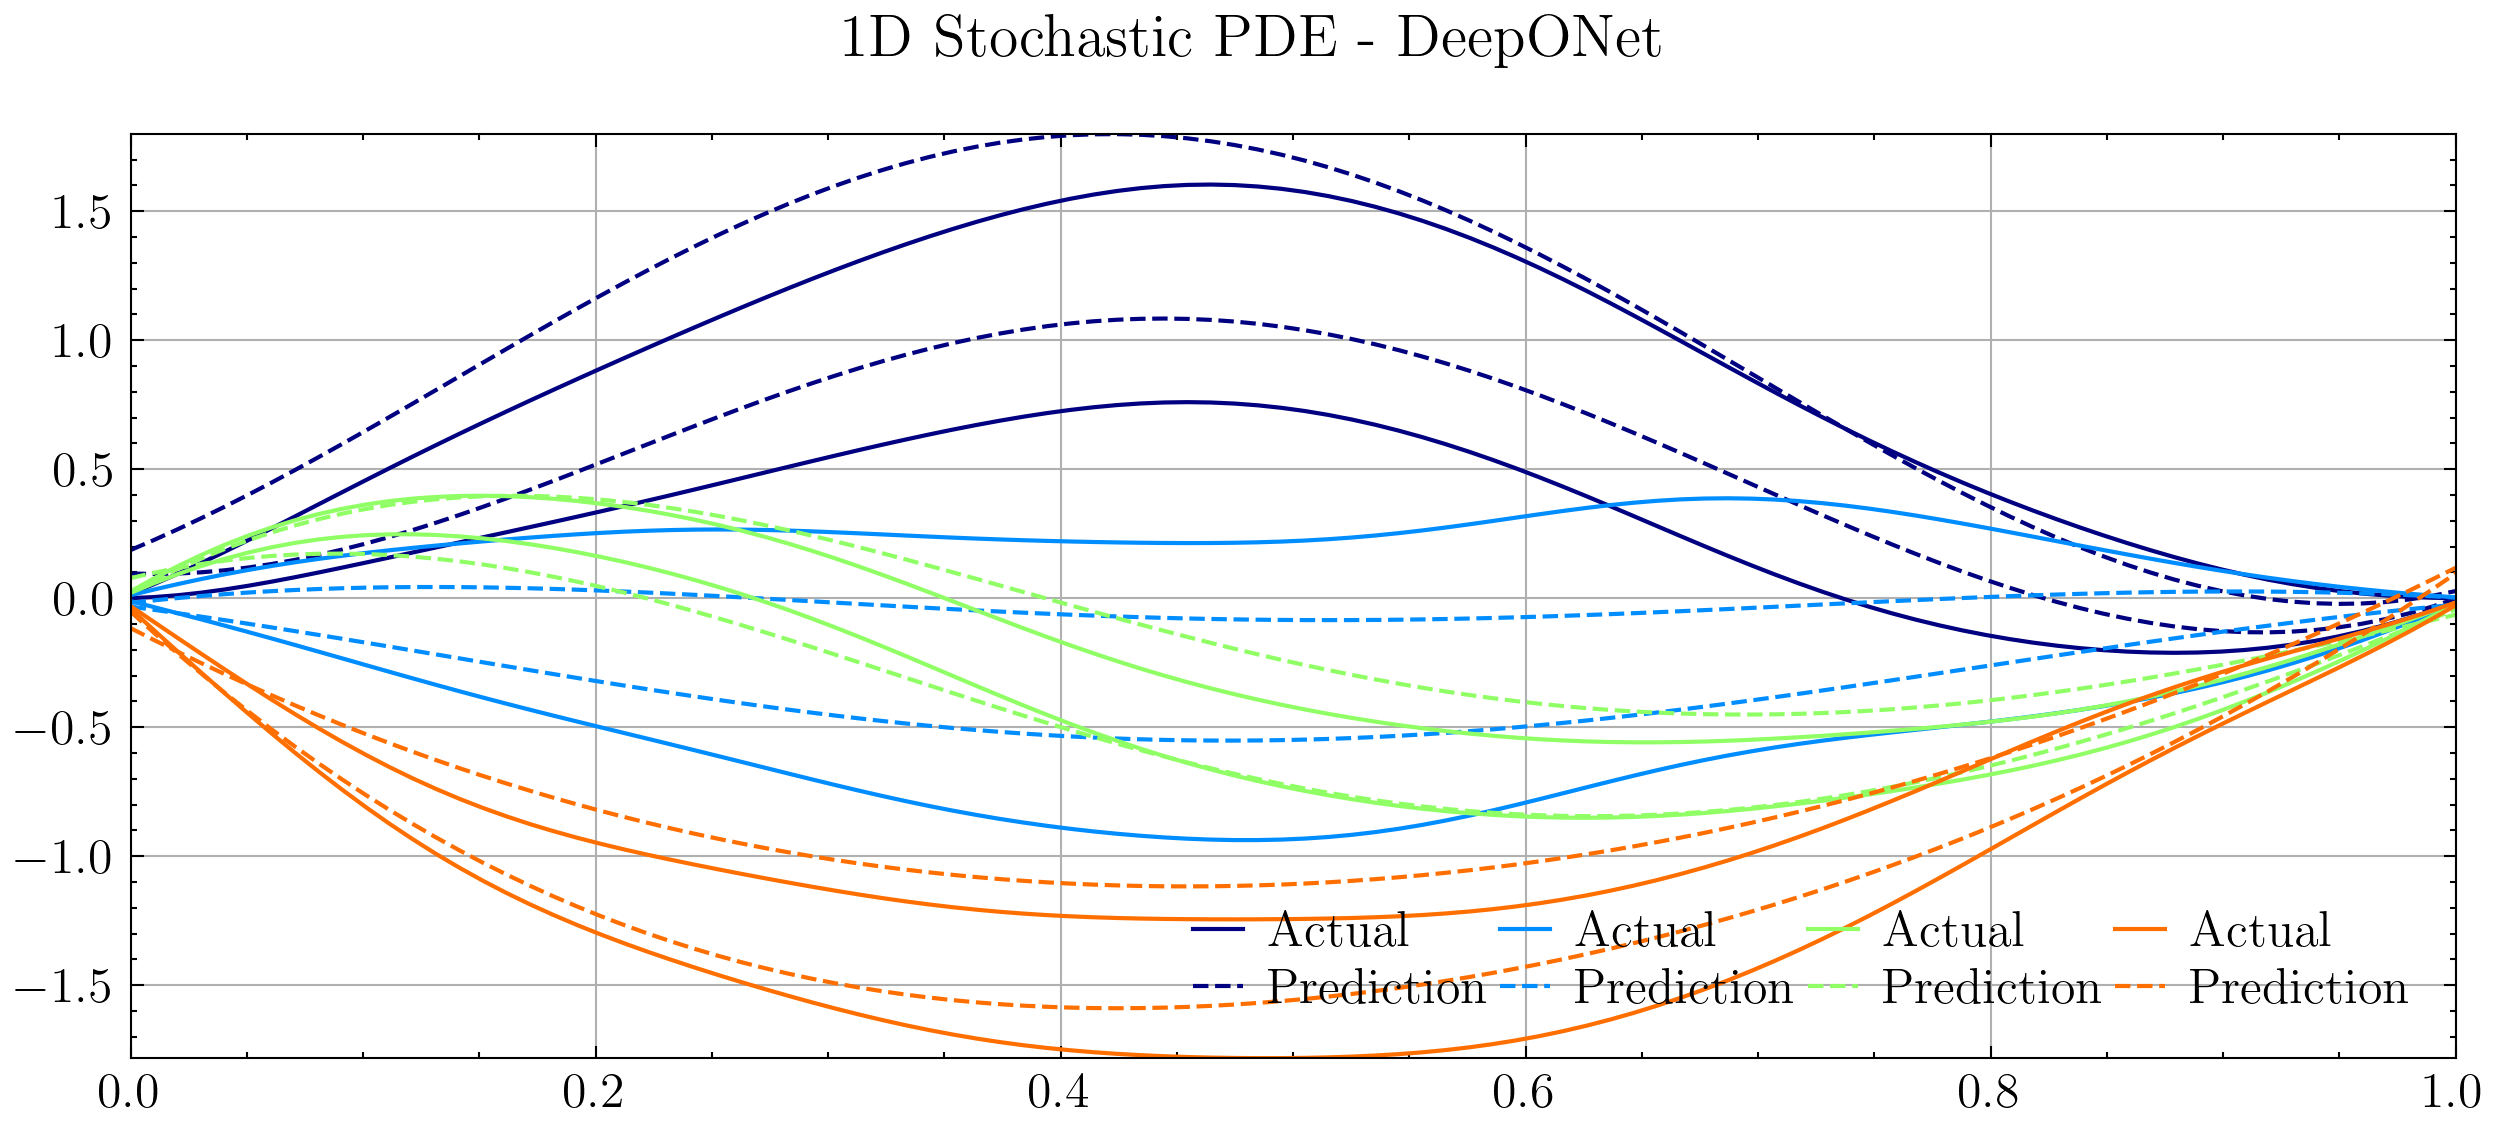

In [28]:
idx=0
preds = results[idx]["pred"]
g_int_test = results[idx]["g_test"]

plt.rcParams['font.family'] = 'Times New Roman' 
plt.rcParams['font.size'] = 12
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

colormap = plt.cm.jet  
colors = [colormap(i) for i in np.linspace(0, 5, 20)]

fig2 = plt.figure(figsize = (10, 4), dpi=300)
fig2.suptitle('1D Stochastic PDE - DeepONet')

index = 0
for i in [39,66,77,99]:
    plt.plot(y_space, g_int_test[i,:,:,0], color=colors[index], label='Actual')
    plt.plot(y_space, g_int_test[i,:,:,1], color=colors[index])
    plt.plot(y_space, preds[i,:,0].T, '--', color=colors[index], label='Prediction')
    plt.plot(y_space, preds[i,:,1].T, '--', color=colors[index])
    index += 1
plt.legend(ncol=4, loc=4, labelspacing=0.25, columnspacing=0.25, handletextpad=0.5, handlelength=1)
plt.grid(True)
plt.margins(0)